# DATA DELVERS:

# Preparing Inputs and libraries:


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

import seaborn as sns


In [2]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col = 0)
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col = 0)

### Indexing dataset by the Date:

In [4]:
Date = test['Date'].copy()


train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values(by='Date')
train.set_index('Date', inplace=True)

test['Date'] = pd.to_datetime(test['Date'])
test = test.sort_values(by='Date')
test.set_index('Date', inplace=True)


# Understanding the dataset:

In [5]:
train.head()

,Open,Close,Volume,Strategy
Date,,,,
2015-06-01,66.208486,75.609978,298506300,Hold
2015-06-08,64.116235,74.443331,227974800,Hold
2015-06-15,47.701942,71.140831,250670900,Buy
2015-06-22,54.754816,72.881344,223614300,Hold
2015-06-29,48.031899,66.284718,406814900,Buy


In [6]:
test.head()

,Open,Volume
Date,,
2021-03-01,72.708331,205897600
2021-03-08,73.310886,214095600
2021-03-15,70.610119,151601700
2021-03-22,70.256017,193982500
2021-03-29,68.258324,220238400


# PART 1: Regression

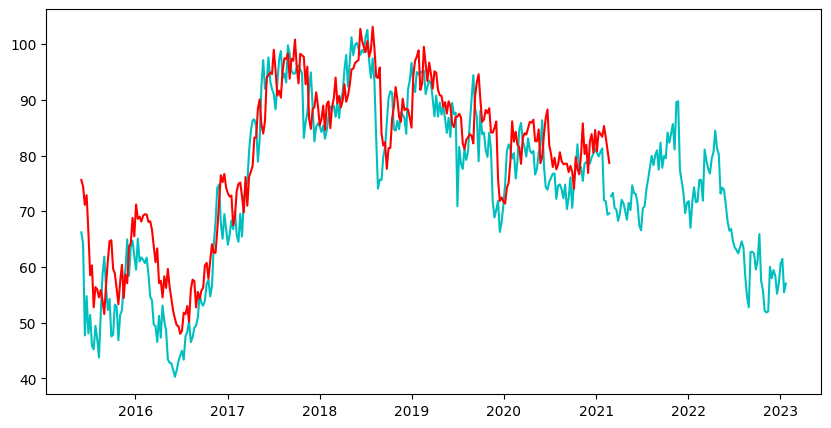

In [7]:
plt.figure(figsize=(10,5))
plt.plot(train['Open'],"c")
plt.plot(test['Open'],"c")
plt.plot(train['Close'],"r")

### The goal is to predict the Close values after 2021

## Analysing relationship between variables:
### correlation plot:

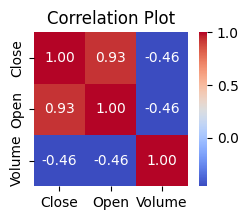

In [8]:
df = train

corr_matrix = df[['Close','Open','Volume']].corr()

plt.figure(figsize=(3, 2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Plot")
plt.show()

#### we see a very high amount of correlation between open and close value. Also a decent bit of correlation between close and Volume.
#### Lets plot and deepen our understanding:

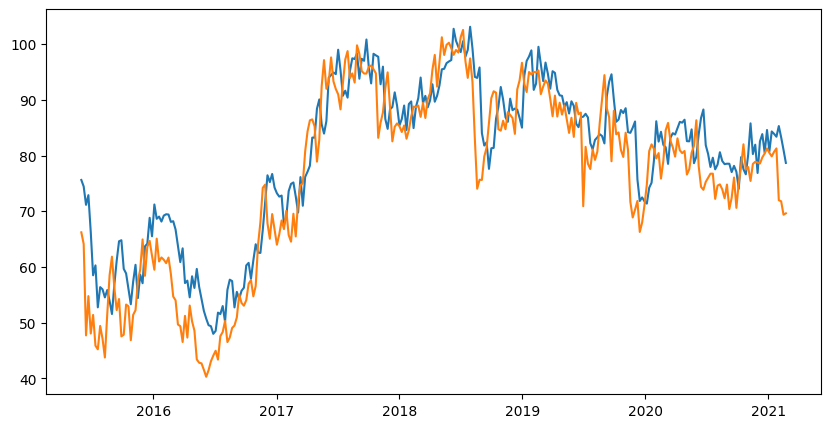

In [9]:
plt.figure(figsize=(10,5))
plt.plot(train['Close'])
plt.plot(train['Open'])

### **INSIGHT** 
#### We see the close and open value have a very similar trend. It almost seems like the close value is the open value but just shifted by some amount.
#### lets create a new column called 'openshift' and plot and see if we can fit the 2 varibles on top of each other

In [10]:
train['OpenShift'] = train['Open'].shift(3)
test['OpenShift'] = test['Open'].shift(3)
train.fillna(train.iloc[3], inplace=True)
test.fillna(test.iloc[3], inplace=True)

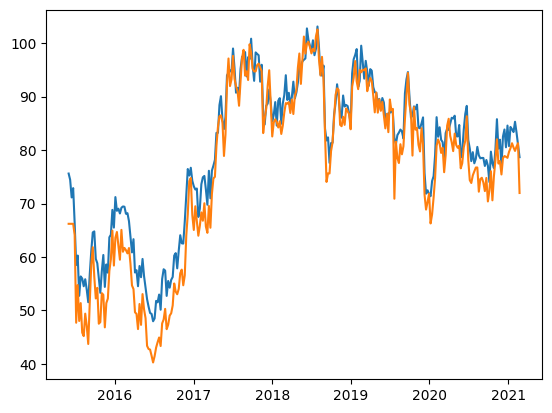

In [11]:
plt.plot(train['Close'])
plt.plot(train['OpenShift'])

### We can see a very good evidence of correlation. Lets just make sure using a corr plot:

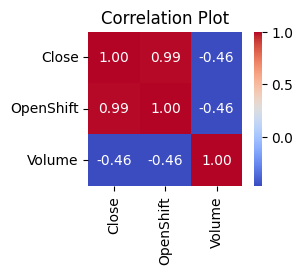

In [12]:
df = train
corr_matrix = df[['Close','OpenShift','Volume']].corr()
plt.figure(figsize=(3, 2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Plot")
plt.show()

### With a little bit of feature engineering, we have obtained OpenShift which has 99% correlation with Close Value !!!  Now we can use this to help predict our close values !

### While we are at it, lets do some feature engineering on Volume too...

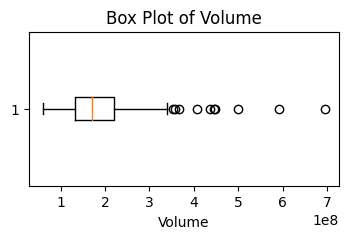

In [13]:
plt.figure(figsize=(4, 2))
plt.boxplot(train['Volume'], vert=False)  # vert=False for a horizontal box plot
plt.title("Box Plot of Volume")
plt.xlabel("Volume")
plt.show()


#### lets  remove outliers and standardise

In [14]:
#for train:

Q1 = train['Volume'].quantile(0.25)
Q3 = train['Volume'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train['Volume'] = train['Volume'].apply(lambda x: x if lower_bound <= x <= upper_bound else pd.NA)
train['Volume'].fillna(method='ffill', inplace=True)

scaler = StandardScaler()

train['Volume'] = scaler.fit_transform(train[['Volume']])

#for test:
Q1 = test['Volume'].quantile(0.25)
Q3 = test['Volume'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

test['Volume'] = test['Volume'].apply(lambda x: x if lower_bound <= x <= upper_bound else pd.NA)
test['Volume'].fillna(method='ffill', inplace=True)

scaler = StandardScaler()

test['Volume'] = scaler.fit_transform(test[['Volume']])


#### lets plot all the variable

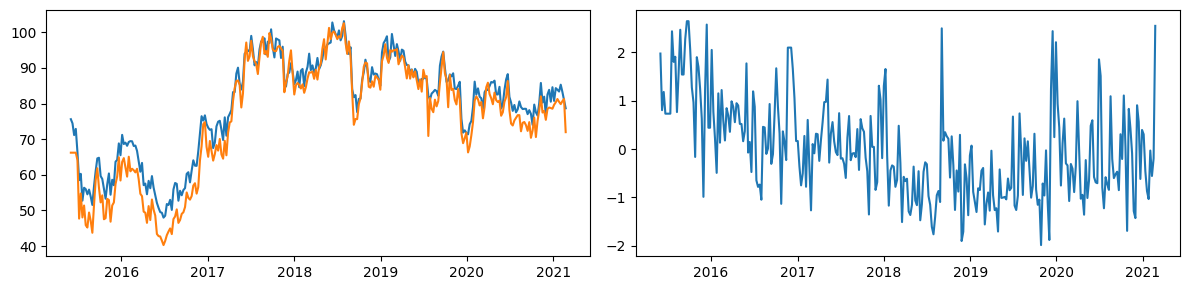

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].plot(train['Close'])
axes[0].plot(train['OpenShift'])
axes[1].plot(train['Volume'])

plt.tight_layout()
plt.show()

### Maybe the difference between close and openshift value is loosely controlled by trend of volume?

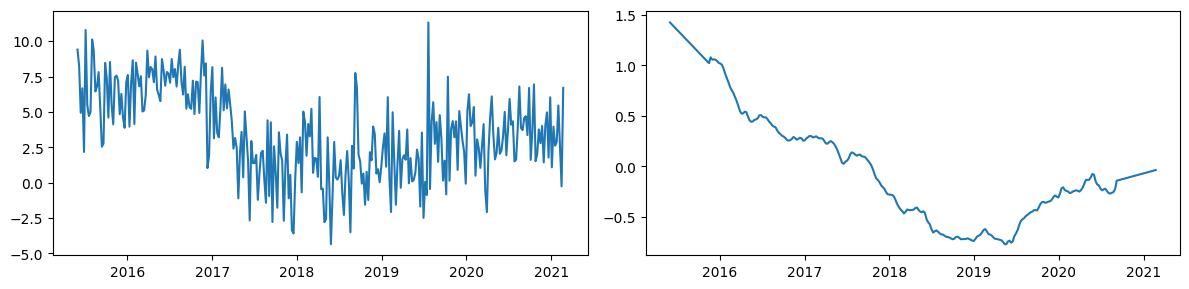

In [16]:
volume_trend = sm.tsa.seasonal_decompose(train.Volume, period=50,extrapolate_trend='freq').trend
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].plot(train['Close'] - train['OpenShift']) 
axes[1].plot(volume_trend)

plt.tight_layout()
plt.show()

train['close-open'] = train['Close'] - train['OpenShift']
train['trendVolume'] = volume_trend


volume_trend = sm.tsa.seasonal_decompose(test.Volume, period=50,extrapolate_trend='freq').trend
test['trendVolume'] = volume_trend

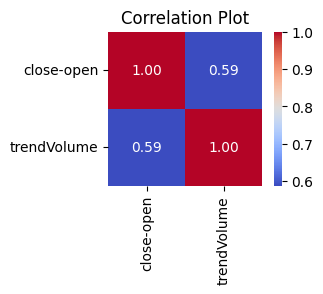

In [17]:
df = train
corr_matrix = df[['close-open','trendVolume']].corr()
plt.figure(figsize=(3, 2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Plot")
plt.show()

#### corr of 0.59, trend of Volume might be useful for our model to predict close price

# BUILDING OUR MODEL:

## We will use SARIMAX for close value regression

### Splitting train into train80 and test20

In [18]:
split_point = int(0.7 * len(train))  
train_80 = train.iloc[:split_point]
test_20 = train.iloc[split_point:]

## For sarimax we need to find p , d , q values....
### lets find d, we need to see if time series is stationary or not:

In [19]:
ts = train['Close']

# Check for stationarity using the Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    return p_value <= 0.05

print("Is the time series stationary?", check_stationarity(ts))

Is the time series stationary? False


### non-stationary
### lets difference ts once:

In [20]:
ts=ts.diff()
ts.fillna(method='bfill', inplace=True)
print("Is the time series stationary?", check_stationarity(ts))


Is the time series stationary? True


### d=1
### lets find p and q:

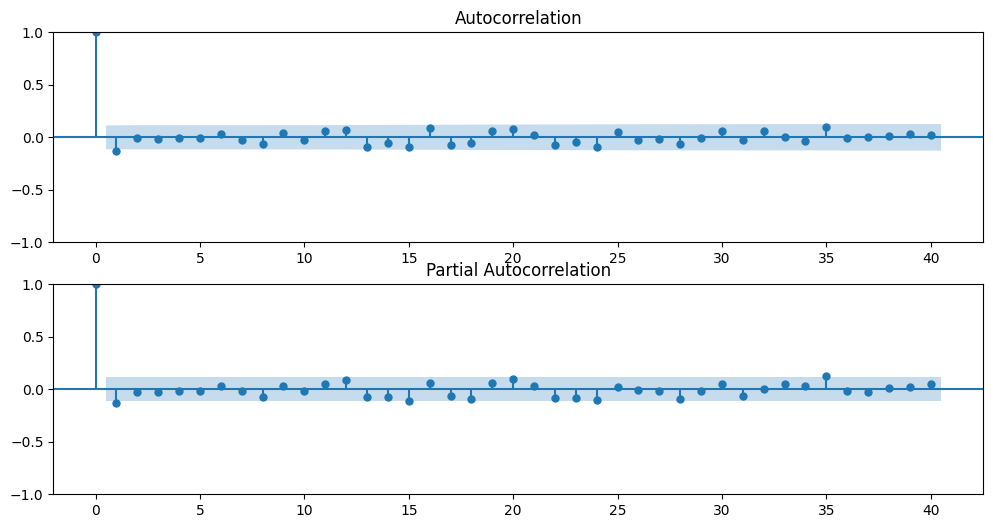

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ts, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts, lags=40, ax=plt.gca())
plt.show()

### p and q can be 0 or 1
### We will use following algorithm to verify p,d,q values:

In [22]:
import warnings
warnings.filterwarnings("ignore")

import itertools 
p=q=range (0,3)
d = range(1,2)
pdq = list(itertools.product (p, d, q))

store = {}
for param in pdq:
       try:
              model_arima = sm.tsa.arima.ARIMA (train.Close, order = param)
              model_arima_fit = model_arima.fit()
              store[param] =  model_arima_fit.aic  
       except:
              continue
          
sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
print(sorted_dict)

{(0, 1, 1): 1554.1036633204, (1, 1, 0): 1554.3060691055864, (1, 1, 1): 1556.023560181878, (0, 1, 2): 1556.0509329333477, (2, 1, 0): 1556.1252322868365, (1, 1, 2): 1556.4066336474407, (2, 1, 1): 1557.0949409203222, (0, 1, 0): 1557.4617996748484, (2, 1, 2): 1559.0848000858327}


## Therefore: p,d,q = 0,1,1

### Similarly lets find seasonal P,Q,D,S , we will define endog and exog variables.

## Lets first Try to build model on our train_80 and test_20 to check our SMAPE value

In [23]:
endog_features = 'Close'
exog_features = ['OpenShift','trendVolume']

endog = train_80[endog_features]
exog = train_80[exog_features]

In [24]:

# Define a range of values for P, Q, D, and S
p_values = [0,1, 2]
d_values = [1]
q_values = [0,1, 2]
s_values = [12]  # Assumeing there is seasonal co

best_aic = float("inf")
best_params = (0, 0, 0, 12)

# Perform a grid search to find the best parameters
for p, d, q, s in itertools.product(p_values, d_values, q_values, s_values):
    mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(0, 1, 1), seasonal_order=(p, d, q, s), enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit(disp=False)
    aic = results.aic
    print((p,d,q,s)," has AIC as ",aic)
    if aic < best_aic:
        best_aic = aic
        best_params = (p, d, q, s)

print(f"Best SARIMA Parameters: (p, d, q, s) = {best_params}")
print(f"Best AIC: {best_aic}")


(0, 1, 0, 12)  has AIC as  952.1825221163215
(0, 1, 1, 12)  has AIC as  797.6217481172037
(0, 1, 2, 12)  has AIC as  746.317173125434
(1, 1, 0, 12)  has AIC as  856.6538498550105
(1, 1, 1, 12)  has AIC as  799.6576397824152
(1, 1, 2, 12)  has AIC as  743.8636722958377
(2, 1, 0, 12)  has AIC as  777.4195322804029
(2, 1, 1, 12)  has AIC as  758.4169881043658
(2, 1, 2, 12)  has AIC as  748.8966213875798
Best SARIMA Parameters: (p, d, q, s) = (1, 1, 2, 12)
Best AIC: 743.8636722958377


In [25]:
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(0, 1, 1), seasonal_order=(1,1,2,12),enforce_stationarity=False, enforce_invertibility=False)
model_fit = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85347D+00    |proj g|=  2.26485D-01


 This problem is unconstrained.



At iterate    5    f=  1.76636D+00    |proj g|=  2.12192D-02

At iterate   10    f=  1.76560D+00    |proj g|=  3.69817D-03

At iterate   15    f=  1.76259D+00    |proj g|=  2.00048D-02

At iterate   20    f=  1.74500D+00    |proj g|=  9.20421D-02

At iterate   25    f=  1.73984D+00    |proj g|=  1.50321D-01

At iterate   30    f=  1.73794D+00    |proj g|=  9.51571D-03

At iterate   35    f=  1.73777D+00    |proj g|=  1.92403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     48      1     0     0   1.723D-05   1.738D+00
  F =   1.7377706483234230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [26]:
exog_test = test_20[exog_features]

predict = model_fit.predict(start = len(train_80),end = len(train_80)+len(test_20) - 1, exog=exog_test)
test_20['predicted'] = predict.values

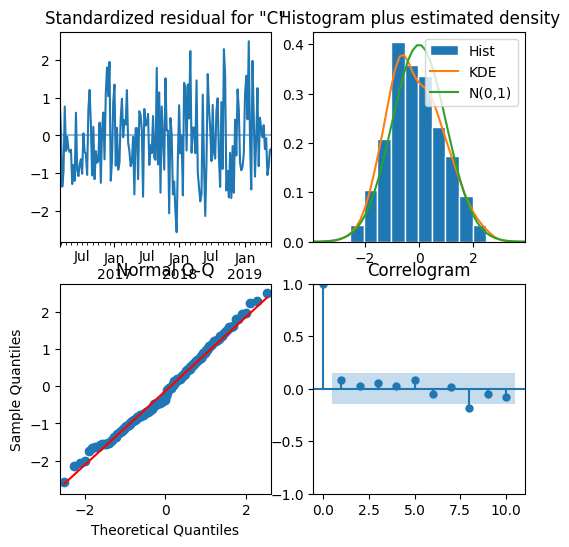

In [27]:
model_fit.plot_diagnostics(figsize=(6,6))
plt.show()

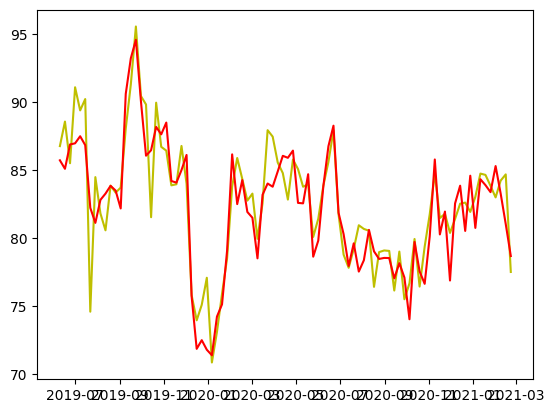

In [28]:
plt.plot(test_20['predicted'],'y')
plt.plot(test_20['Close'],'r')


In [29]:
smape = np.mean(np.abs(test_20['predicted'] - test_20['Close']) / (np.abs(test_20['predicted']) + np.abs(test_20['Close'])))
smape

0.010151869257536571

### We can see that our model is fitting nicely on our known test set... 

# Lets Build it on the actually train and test dataset now

In [30]:
endog = train['Close']
exog = train[['OpenShift','trendVolume']]

In [31]:
mod = sm.tsa.statespace.SARIMAX(endog=endog,exog=exog, order=(0,1,1),enforce_stationarity=False, enforce_invertibility=False)
model_fit = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17580D+00    |proj g|=  5.44295D-01

At iterate    5    f=  2.07044D+00    |proj g|=  5.94794D-01

At iterate   10    f=  2.06669D+00    |proj g|=  1.59568D-02

At iterate   15    f=  2.06353D+00    |proj g|=  1.35357D-01

At iterate   20    f=  2.06307D+00    |proj g|=  3.41231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   3.870D-05   2.063D+00
  F =   2.0630658929088668     

CONVERG

 This problem is unconstrained.


In [32]:
exog_test = test[['OpenShift','trendVolume']]

predict = model_fit.predict(start = len(train),end = len(train)+len(test) - 1, exog=exog_test)
test['predicted'] = predict.values

test['predicted']

Date
2021-03-01    76.776187
2021-03-08    76.774467
2021-03-15    76.772747
2021-03-22    76.771027
2021-03-29    77.278555
                ...    
2022-12-26    65.389113
2023-01-02    64.533450
2023-01-09    61.798806
2023-01-16    63.372889
2023-01-23    66.346966
Name: predicted, Length: 100, dtype: float64

# WE HAVE SUCCESSFULLY PREDICTED CLOSE PRICE FOR THE TEST DATA SET

### Lets plot and check. From our EDA , we know that the close price has a 0.99 correlation to OpenShift column meaning they both should follow same trends...

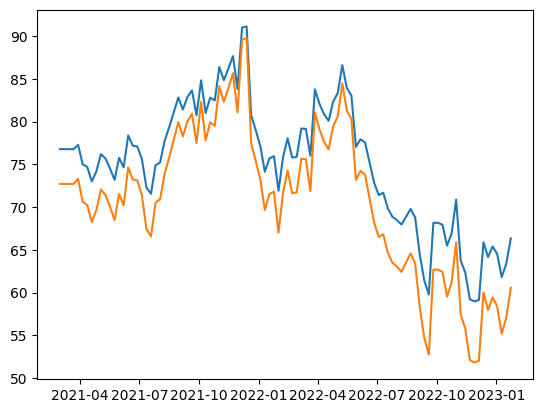

In [33]:
plt.plot(test['predicted'])
plt.plot(test['OpenShift'])

## We have satisifactory results from our model for predicting close price!
### Lets now plot the complete close and open prices of stocks for all the years !

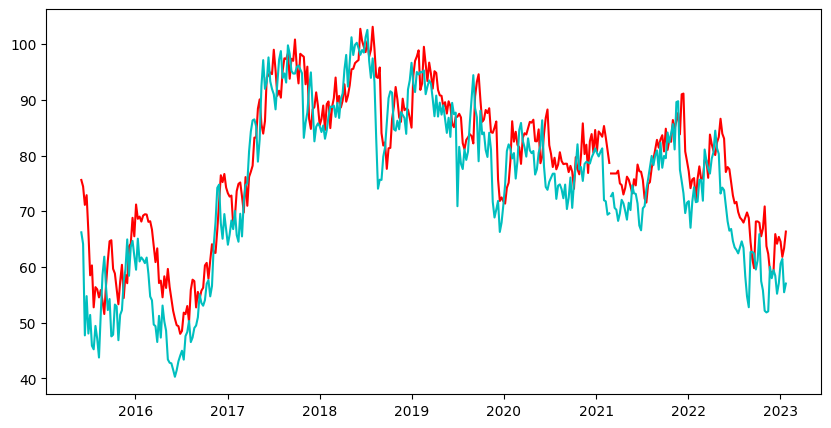

In [34]:
plt.figure(figsize=(10,5))
plt.plot(train['Close'],'r')
plt.plot(train['Open'],'c')

plt.plot(test['predicted'],'r')
plt.plot(test['Open'],'c')

# PART 2 :
# Classifying Sell,Hold,Open prices for test dataset :

# EDA:

## Lets plot the close values of train along with the corresopnding Strategy and see if there is a pattern.

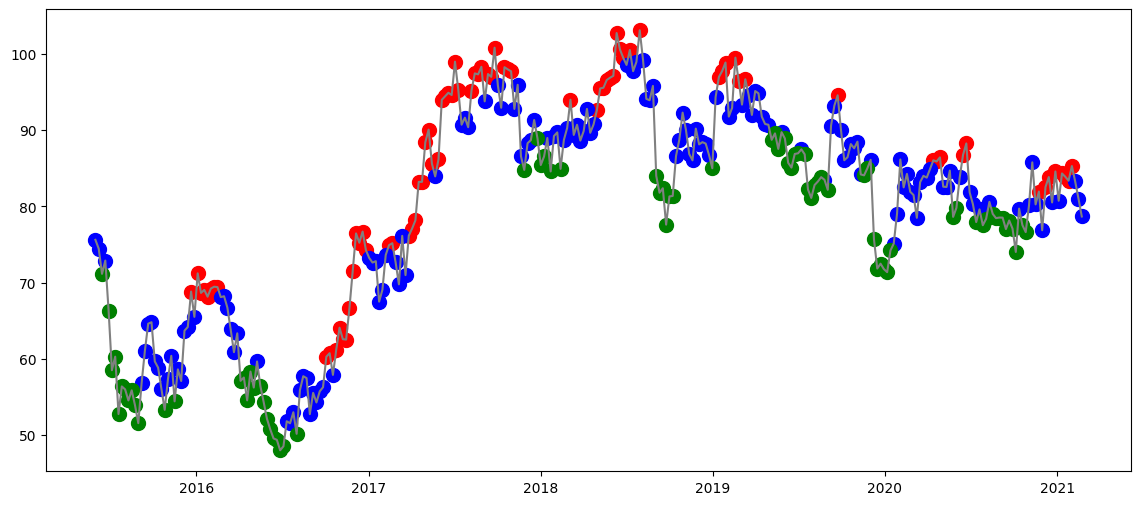

In [35]:
def plotStrategy(train,feature='Close'):
    plt.figure(figsize=(14,6))
    plt.plot(train[feature],"grey")

    colors = {'Sell': 'red', 'Hold': 'blue', 'Buy': 'green'}

    for strategy in colors.keys():
        strategy_data = train[train['Strategy'] == strategy]
        plt.scatter(strategy_data.index, strategy_data[feature], label=strategy, color=colors[strategy], s=100)
plotStrategy(train)

## We can see that when the close price is at local maxima, or at an all time high, it is classified as sell and when it at a local minima, it is classified as Buy, rest is Hold...

# We will use RandomForestClassifier as our classification model. But first lets do feature engineering and create additional variables to help our model learn better.

### Since Train and Test are continuous timeseries dataset, lets combine both and create additional features...

In [36]:
train_data = train.copy()
test_data = test.copy()

test_data['Close'] = test_data['predicted']


Dataset = pd.concat([train_data,test_data],axis=0)

In [37]:
Dataset

,Open,Close,Volume,Strategy,OpenShift,close-open,trendVolume,predicted
Date,,,,,,,,
2015-06-01,66.208486,75.609978,1.976309,Hold,66.208486,9.401492,1.422758,NaN
2015-06-08,64.116235,74.443331,0.804527,Hold,66.208486,8.234845,1.405991,NaN
2015-06-15,47.701942,71.140831,1.181591,Buy,66.208486,4.932346,1.389224,NaN
2015-06-22,54.754816,72.881344,0.732083,Hold,66.208486,6.672858,1.372457,NaN
2015-06-29,48.031899,66.284718,0.732083,Buy,64.116235,2.168483,1.355691,NaN
...,...,...,...,...,...,...,...,...
2022-12-26,57.048622,65.389113,0.605116,NaN,59.428165,NaN,0.402328,65.389113
2023-01-02,60.569661,64.533450,-0.366769,NaN,58.417757,NaN,0.411845,64.533450
2023-01-09,61.446777,61.798806,-0.258454,NaN,55.184092,NaN,0.421362,61.798806


In [38]:
train_data

,Open,Close,Volume,Strategy,OpenShift,close-open,trendVolume
Date,,,,,,,
2015-06-01,66.208486,75.609978,1.976309,Hold,66.208486,9.401492,1.422758
2015-06-08,64.116235,74.443331,0.804527,Hold,66.208486,8.234845,1.405991
2015-06-15,47.701942,71.140831,1.181591,Buy,66.208486,4.932346,1.389224
2015-06-22,54.754816,72.881344,0.732083,Hold,66.208486,6.672858,1.372457
2015-06-29,48.031899,66.284718,0.732083,Buy,64.116235,2.168483,1.355691
...,...,...,...,...,...,...,...
2021-01-25,81.284821,83.373498,-1.034486,Sell,80.490487,2.883011,-0.054693
2021-02-01,71.970249,85.294903,-0.031453,Sell,79.840215,5.454688,-0.050309
2021-02-08,71.784627,83.266453,-0.557312,Hold,80.663736,2.602716,-0.045926


In [39]:
Dataset['1_MA'] = Dataset['Close'].rolling(window=10).mean()
Dataset['2_MA'] = Dataset['Close'].rolling(window=49).mean()
Dataset['monthly_MA'] = Dataset['Close'].rolling(window=5).mean()
Dataset['quarter_MA'] = Dataset['Close'].rolling(window=12).mean()
Dataset['year_MA'] = Dataset['Close'].rolling(window=52).mean()
Dataset['20_MA'] = Dataset['Close'].rolling(window=20).mean()
# Dataset['diff'] = Dataset['Close'].diff(2)


# Calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=10):
    diff = data['Close'].diff()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

Dataset['RSI'] = calculate_rsi(Dataset)


short_window = 12  # Short-term EMA period
long_window = 26  # Long-term EMA period

Dataset['Short_EMA'] = Dataset['Close'].ewm(span=short_window, adjust=False).mean()
Dataset['Long_EMA'] = Dataset['Close'].ewm(span=long_window, adjust=False).mean()

# Calculate the MACD line
Dataset['MACD'] = Dataset['Short_EMA'] - Dataset['Long_EMA']

# Calculate the signal line (9-day EMA of the MACD)
signal_window = 9
Dataset['Signal_Line'] = Dataset['MACD'].ewm(span=signal_window, adjust=False).mean()

Dataset['min'] = Dataset['Close'].rolling(window=17, min_periods=1).min()
Dataset['max'] = Dataset['Close'].rolling(window=17, min_periods=1).max()

Dataset['min-max'] = (Dataset['Close']-Dataset['min'])/(Dataset['max']-Dataset['min'])

Dataset.fillna(method='ffill', inplace=True)
Dataset.fillna(method='bfill', inplace=True)

In [40]:
window = 14  # The period for the Stochastic Oscillator
k_window = 3  # The smoothing factor for %K
d_window = 3 
# Calculate the lowest low and highest high over the specified window
Dataset['Lowest_Low'] = Dataset['Close'].rolling(window=window).min()
Dataset['Highest_High'] = Dataset['Close'].rolling(window=window).max()
Dataset['Lowest_Low'].fillna(method='bfill', inplace=True)
Dataset['Highest_High'].fillna(method='bfill', inplace=True)

# Calculate %K
Dataset['%K'] = (Dataset['Close'] - Dataset['Lowest_Low']) / (Dataset['Highest_High'] - Dataset['Lowest_Low']) * 100

# Smooth %K to calculate %D
Dataset['%D'] = Dataset['%K'].rolling(window=k_window).mean()

# Smooth %D further if needed
Dataset['%D'] = Dataset['%D'].rolling(window=d_window).mean()

Dataset['%K'].fillna(method='bfill', inplace=True)
Dataset['%D'].fillna(method='bfill', inplace=True)

In [41]:
Dataset.columns.tolist()

['Open',
 'Close',
 'Volume',
 'Strategy',
 'OpenShift',
 'close-open',
 'trendVolume',
 'predicted',
 '1_MA',
 '2_MA',
 'monthly_MA',
 'quarter_MA',
 'year_MA',
 '20_MA',
 'RSI',
 'Short_EMA',
 'Long_EMA',
 'MACD',
 'Signal_Line',
 'min',
 'max',
 'min-max',
 'Lowest_Low',
 'Highest_High',
 '%K',
 '%D']

In [42]:
Dataset['Returns'] = Dataset['Close'].pct_change()

# Calculate the Standard Deviation of Returns
std_deviation = Dataset['Returns'].std()
window = 20  # Adjust the window as needed
Dataset['RollingMean'] = Dataset['Close'].rolling(window=window).mean()
Dataset['UpperBand'] = Dataset['RollingMean'] + (2 * Dataset['Returns'].rolling(window=window).std())
Dataset['LowerBand'] = Dataset['RollingMean'] - (2 * Dataset['Returns'].rolling(window=window).std())

Dataset['UpperBand'].fillna(method='bfill', inplace=True)
Dataset['LowerBand'].fillna(method='bfill', inplace=True)
Dataset['RollingMean'].fillna(method='bfill', inplace=True)
Dataset['Returns'].fillna(method='bfill', inplace=True)

In [43]:
import pandas as pd

# Assuming you already have a DataFrame dataset with existing features

# Lagged Returns
Dataset['1_Day_Return'] = Dataset['Close'].pct_change(periods=1)
Dataset['3_Day_Return'] = Dataset['Close'].pct_change(periods=3)
Dataset['5_Day_Return'] = Dataset['Close'].pct_change(periods=5)


window_size = 17  # Adjust the window size as needed
Dataset['High'] = Dataset['Close'].rolling(window=window_size, min_periods=1).max()

# Calculate the 'Low' column using a rolling window
window_size = 17  # Adjust the window size as needed
Dataset['Low'] = Dataset['Close'].rolling(window=window_size, min_periods=1).min()
# Volatility Measures
Dataset['ATR'] = Dataset['High'] - Dataset['Low']

# Moving Average Crossovers
Dataset['50_200_MA_Crossover'] = (Dataset['Close'].rolling(window=50).mean() > Dataset['Close'].rolling(window=200).mean()).astype(int)

# MACD Histogram
Dataset['MACD_Histogram'] = Dataset['MACD'] - Dataset['Signal_Line']

# RSI Divergence
# Implement RSI divergence detection logic here

# On-Balance Volume (OBV)
Dataset['OBV'] = (Dataset['Volume'] * (2 * (Dataset['Close'] > Dataset['Close'].shift(1)) - 1)).cumsum()

# Bollinger Bands Width
Dataset['Bollinger_Band_Width'] = (Dataset['UpperBand'] - Dataset['LowerBand']) / Dataset['RollingMean']

# Fibonacci Retracement Levels
# Implement Fibonacci retracement calculations here

# Price Rate of Change (ROC)
Dataset['ROC'] = (Dataset['Close'] - Dataset['Close'].shift(1)) / Dataset['Close'].shift(1)

# Display the updated DataFrame with new features
print(Dataset[:2])


                 Open      Close    Volume Strategy  OpenShift  close-open  \
Date                                                                         
2015-06-01  66.208486  75.609978  1.976309     Hold  66.208486    9.401492   
2015-06-08  64.116235  74.443331  0.804527     Hold  66.208486    8.234845   

            trendVolume  predicted       1_MA       2_MA  ...  3_Day_Return  \
Date                                                      ...                 
2015-06-01     1.422758  76.776187  64.420097  62.139846  ...           NaN   
2015-06-08     1.405991  76.776187  64.420097  62.139846  ...           NaN   

            5_Day_Return       High        Low       ATR  50_200_MA_Crossover  \
Date                                                                            
2015-06-01           NaN  75.609978  75.609978  0.000000                    0   
2015-06-08           NaN  75.609978  74.443331  1.166647                    0   

            MACD_Histogram       OBV  Bolling

In [44]:
Dataset['ROC'].fillna(method='bfill', inplace=True)
Dataset['OBV'].fillna(method='bfill', inplace=True)
Dataset['1_Day_Return'].fillna(method='bfill', inplace=True)
Dataset['3_Day_Return'].fillna(method='bfill', inplace=True)
Dataset['5_Day_Return'].fillna(method='bfill', inplace=True)

In [45]:
train_data=Dataset[:300]
test_data=Dataset[300:]

In [46]:
# train_data['Close_Prev'] = train_data['Close'].shift(1)  # Shift the 'Close' column by one to get 'Close_Prev'
# train_data['Close_Next'] = train_data['Close'].shift(-1)
# train_data['Close_Prev'].fillna(method='bfill', inplace=True)
# train_data['Close_Next'].fillna(method='ffill', inplace=True)
# train_data['Returns'] = train_data['Close'].pct_change()

# Calculate the Standard Deviation of Returns
# std_deviation = train_data['Returns'].std()
# window = 20  # Adjust the window as needed
# train_data['RollingMean'] = train_data['Close'].rolling(window=window).mean()
# train_data['UpperBand'] = train_data['RollingMean'] + (2 * train_data['Returns'].rolling(window=window).std())
# train_data['LowerBand'] = train_data['RollingMean'] - (2 * train_data['Returns'].rolling(window=window).std())

# train_data['UpperBand'].fillna(method='bfill', inplace=True)
# train_data['LowerBand'].fillna(method='bfill', inplace=True)
# train_data['RollingMean'].fillna(method='bfill', inplace=True)
# train_data['Returns'].fillna(method='bfill', inplace=True)

In [47]:
# test_data['Returns'] = test_data['Close'].pct_change()

# # Calculate the Standard Deviation of Returns
# std_deviation = test_data['Returns'].std()
# window = 20  # Adjust the window as needed
# test_data['RollingMean'] = test_data['Close'].rolling(window=window).mean()
# test_data['UpperBand'] = test_data['RollingMean'] + (2 * test_data['Returns'].rolling(window=window).std())
# test_data['LowerBand'] = test_data['RollingMean'] - (2 * test_data['Returns'].rolling(window=window).std())

# test_data['UpperBand'].fillna(method='bfill', inplace=True)
# test_data['LowerBand'].fillna(method='bfill', inplace=True)
# test_data['RollingMean'].fillna(method='bfill', inplace=True)
# test_data['Returns'].fillna(method='bfill', inplace=True)

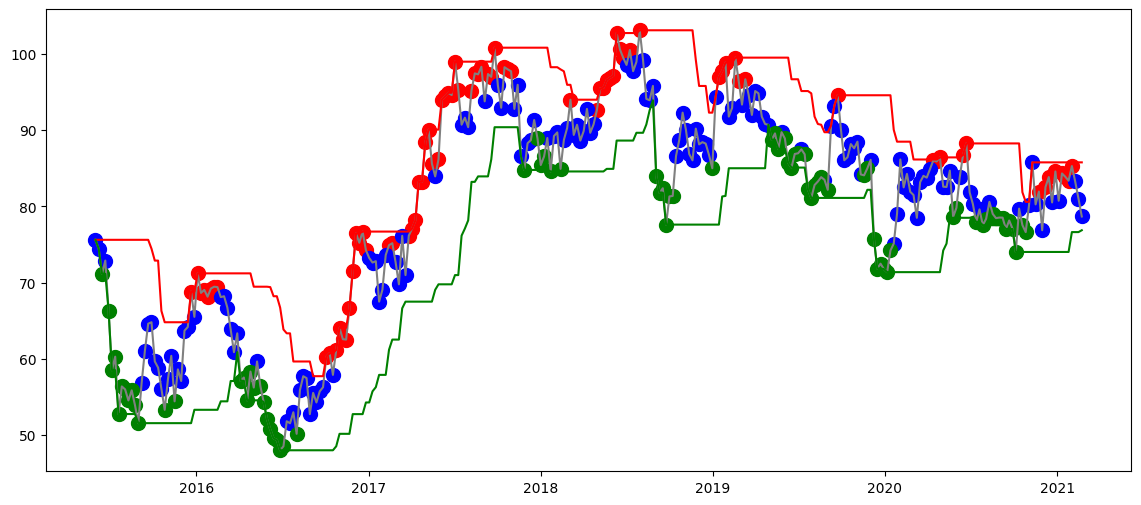

In [48]:
plotStrategy(Dataset[:300])
plt.plot(Dataset[:300]['max'],'r')
plt.plot(Dataset[:300]['min'],'g')

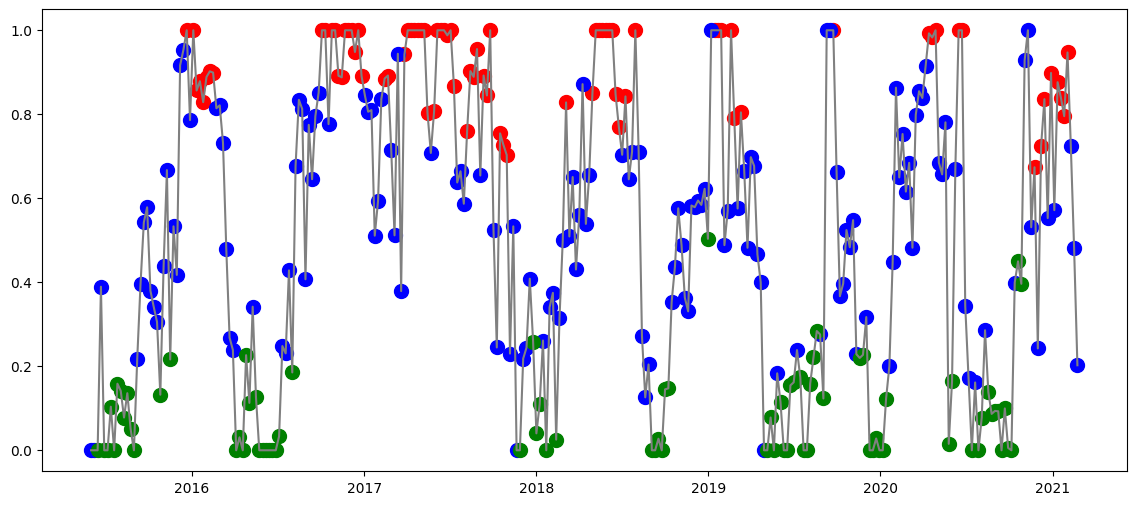

In [49]:
plotStrategy(Dataset[:300],'min-max')

In [50]:
print(train_data.columns.tolist())

['Open', 'Close', 'Volume', 'Strategy', 'OpenShift', 'close-open', 'trendVolume', 'predicted', '1_MA', '2_MA', 'monthly_MA', 'quarter_MA', 'year_MA', '20_MA', 'RSI', 'Short_EMA', 'Long_EMA', 'MACD', 'Signal_Line', 'min', 'max', 'min-max', 'Lowest_Low', 'Highest_High', '%K', '%D', 'Returns', 'RollingMean', 'UpperBand', 'LowerBand', '1_Day_Return', '3_Day_Return', '5_Day_Return', 'High', 'Low', 'ATR', '50_200_MA_Crossover', 'MACD_Histogram', 'OBV', 'Bollinger_Band_Width', 'ROC']


In [51]:
print(test_data.columns.tolist())

['Open', 'Close', 'Volume', 'Strategy', 'OpenShift', 'close-open', 'trendVolume', 'predicted', '1_MA', '2_MA', 'monthly_MA', 'quarter_MA', 'year_MA', '20_MA', 'RSI', 'Short_EMA', 'Long_EMA', 'MACD', 'Signal_Line', 'min', 'max', 'min-max', 'Lowest_Low', 'Highest_High', '%K', '%D', 'Returns', 'RollingMean', 'UpperBand', 'LowerBand', '1_Day_Return', '3_Day_Return', '5_Day_Return', 'High', 'Low', 'ATR', '50_200_MA_Crossover', 'MACD_Histogram', 'OBV', 'Bollinger_Band_Width', 'ROC']


In [52]:
train_data.isna().sum()

Open                    0
Close                   0
Volume                  0
Strategy                0
OpenShift               0
close-open              0
trendVolume             0
predicted               0
1_MA                    0
2_MA                    0
monthly_MA              0
quarter_MA              0
year_MA                 0
20_MA                   0
RSI                     0
Short_EMA               0
Long_EMA                0
MACD                    0
Signal_Line             0
min                     0
max                     0
min-max                 0
Lowest_Low              0
Highest_High            0
%K                      0
%D                      0
Returns                 0
RollingMean             0
UpperBand               0
LowerBand               0
1_Day_Return            0
3_Day_Return            0
5_Day_Return            0
High                    0
Low                     0
ATR                     0
50_200_MA_Crossover     0
MACD_Histogram          0
OBV         

In [53]:
import lightgbm as lgb
# Load your preprocessed train dataset
# Define the features and target variable
# features = ['1_MA','RSI','Close','2_MA']

# features = ['1_MA','RSI','Close','2_MA','min','max','Signal_Line','MACD','min-max','RollingMean','UpperBand','LowerBand','Returns']
# features = ['monthly_MA','RSI','Close','quarter_MA','year_MA','min','max','Signal_Line','MACD','min-max','RollingMean','UpperBand','LowerBand','Returns'] 11.42
# features = ['%K','%D','RSI','MACD','min-max','Signal_Line','Close','Returns','1_MA','2_MA','RollingMean']
# features = ['20_MA','1_MA','RSI','MACD','Signal_Line','min-max','min','max','Close']
# features = ['1_MA','RSI','Close','2_MA','min','max','Signal_Line','MACD','min-max']
# features = ['Open', 'Close','OpenShift', 'close-open', 'trendVolume', 'predicted', '1_MA', '2_MA', 'RSI', 'Short_EMA', 'Long_EMA', 'MACD', 'Signal_Line', 'min', 'max', 'min-max', '20_MA', '%K', '%D', 'Returns', 'RollingMean', 'UpperBand', 'LowerBand','Lowest_Low','Highest_High']
# features = ['Open','Close','Volume','OpenShift','RSI','MACD','Signal_Line','min-max','monthly_MA','%K','%D']
features = ['MACD_Histogram','MACD','Signal_Line','1_Day_Return','3_Day_Return','5_Day_Return','UpperBand','LowerBand','RSI','min-max','min','max','50_200_MA_Crossover']  #83.33
# features = ['MACD_Histogram','MACD','1_Day_Return','5_Day_Return','UpperBand','LowerBand','RSI','min-max','min','max','50_200_MA_Crossover','Short_EMA','Long_EMA']

X = train_data[features]
y = train_data['Strategy']

# Split the data into training and validation sets
split_point = int(0.8 * len(X))  
X_train = X.iloc[:split_point]
X_valid = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_valid = y.iloc[split_point:]

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=500, random_state=42)
# clf = lgb.LGBMClassifier(n_estimators=200, random_state=42)

clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf.predict(X_valid)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_valid, y_pred)
classification_rep = classification_report(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)


Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

         Buy       0.88      0.82      0.85        17
        Hold       0.79      0.90      0.84        30
        Sell       0.90      0.69      0.78        13

    accuracy                           0.83        60
   macro avg       0.86      0.81      0.82        60
weighted avg       0.84      0.83      0.83        60



In [54]:
X_train = train_data[features]
y_train = train_data['Strategy']

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


test_features = test_data[features] 

test_predictions = clf.predict(test_features)  

print(test_predictions)

['Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Hold' 'Buy' 'Buy'
 'Buy' 'Hold' 'Buy' 'Hold' 'Hold' 'Hold' 'Hold' 'Buy' 'Buy' 'Hold' 'Hold'
 'Hold' 'Hold' 'Sell' 'Sell' 'Sell' 'Sell' 'Sell' 'Hold' 'Sell' 'Hold'
 'Sell' 'Hold' 'Sell' 'Sell' 'Sell' 'Sell' 'Hold' 'Sell' 'Sell' 'Hold'
 'Hold' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Hold' 'Buy' 'Buy' 'Hold'
 'Hold' 'Buy' 'Hold' 'Hold' 'Hold' 'Hold' 'Sell' 'Sell' 'Sell' 'Sell'
 'Hold' 'Hold' 'Hold' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy'
 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold' 'Hold' 'Buy' 'Buy' 'Buy' 'Hold' 'Hold' 'Hold' 'Hold'
 'Hold' 'Hold' 'Hold']


In [55]:
test_data['Strategy']=test_predictions

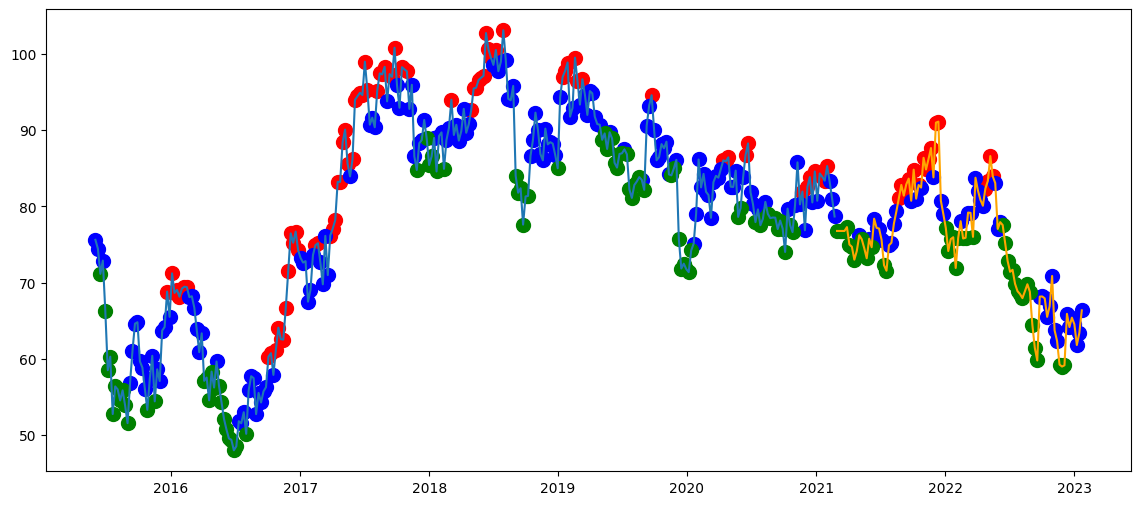

In [56]:

# Print the resulting DataFrame
plt.figure(figsize=(14,6))
plt.plot(train_data['Close'])
plt.plot(test_data['Close'],'orange')

colors = {'Sell': 'red', 'Hold': 'blue', 'Buy': 'green'}

for strategy in colors.keys():
    strategy_data = test_data[test_data['Strategy'] == strategy]
    plt.scatter(strategy_data.index, strategy_data['Close'], label=strategy, color=colors[strategy], s=100)

    
for strategy in colors.keys():
    strategy_data = train_data[train_data['Strategy'] == strategy]
    plt.scatter(strategy_data.index,strategy_data['Close'], label=strategy, color=colors[strategy], s=100)


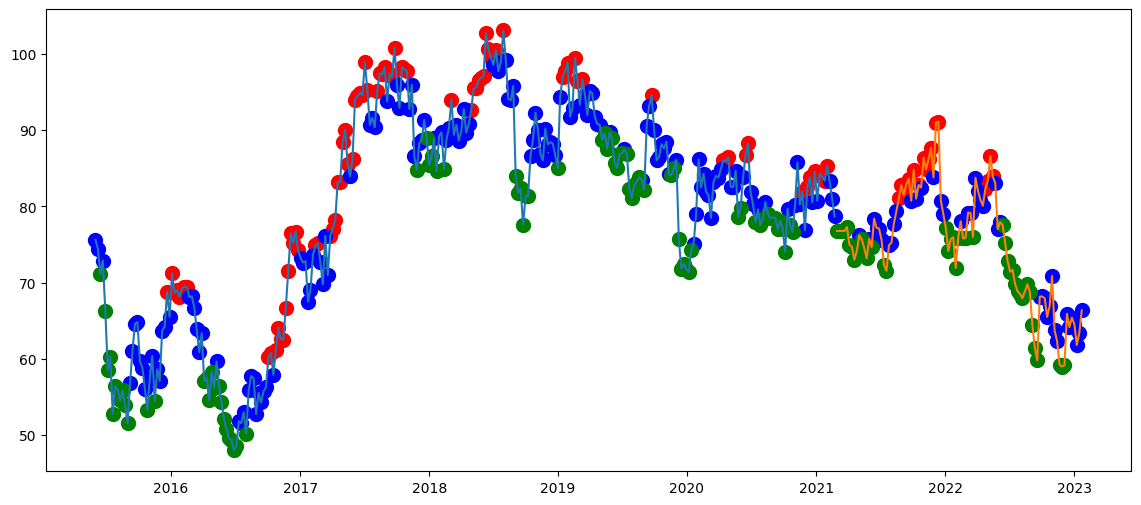

In [57]:

# Print the resulting DataFrame
plt.figure(figsize=(14,6))
plt.plot(train_data['Close'])
plt.plot(test_data['Close'])

colors = {'Sell': 'red', 'Hold': 'blue', 'Buy': 'green'}

for strategy in colors.keys():
    strategy_data = test_data[test_data['Strategy'] == strategy]
    plt.scatter(strategy_data.index, strategy_data['Close'], label=strategy, color=colors[strategy], s=100)

    
for strategy in colors.keys():
    strategy_data = train_data[train_data['Strategy'] == strategy]
    plt.scatter(strategy_data.index,strategy_data['Close'], label=strategy, color=colors[strategy], s=100)


In [58]:
submission = pd.DataFrame()
submission["Date"] = Date

In [59]:
submission["Close"] = predict.values
submission["Strategy"] = test_predictions

In [60]:
submission

,Date,Close,Strategy
id,,,
0,2021-03-01,76.776187,Buy
1,2021-03-08,76.774467,Buy
2,2021-03-15,76.772747,Buy
3,2021-03-22,76.771027,Buy
4,2021-03-29,77.278555,Buy
...,...,...,...
95,2022-12-26,65.389113,Hold
96,2023-01-02,64.533450,Hold
97,2023-01-09,61.798806,Hold


In [61]:
print(len(train_data.columns.tolist()))
# y

41


In [62]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.feature_selection import mutual_info_classif

# # Assuming X contains all your feature columns
# # y contains your 'Strategy' column
# selector = SelectKBest(score_func=f_classif, k='all')
# selector.fit(train_data[['Open', 'Close', 'Volume','OpenShift', 'close-open', 'trendVolume', 'predicted', '1_MA', '2_MA', 'RSI', 'Short_EMA', 'Long_EMA', 'MACD', 'Signal_Line', 'min', 'max', 'min-max', 'monthly_MA', 'quarter_MA', 'year_MA', 'Returns', 'RollingMean', 'UpperBand', 'LowerBand']], y)

# # Get F-Scores for all features
# f_scores = selector.scores_
# mi_scores = selector.scores_

# # Sort the features based on their F-Scores (higher is better)
# ranked_features_f = [f for f, score in sorted(enumerate(f_scores), key=lambda x: x[1], reverse=True)]
# # Sort the features based on their MI scores (higher is better)
# ranked_features_mi = [f for f, score in sorted(enumerate(mi_scores), key=lambda x: x[1], reverse=True)]

In [63]:
# Choose the top 'k' features based on F-Scores
# k = 10  # Adjust the value of 'k' as needed
# best_features_f = ranked_features_f[:k]

# # Choose the top 'k' features based on MI scores
# best_features_mi = ranked_features_mi[:k]


In [64]:
# print(train_data.columns.tolist())

In [65]:
# best_features_f

In [66]:
# best_features_mi

In [67]:
# plt.plot(train['Close'],"r")
# plt.plot(train['OpenShift'])

In [68]:
# submission

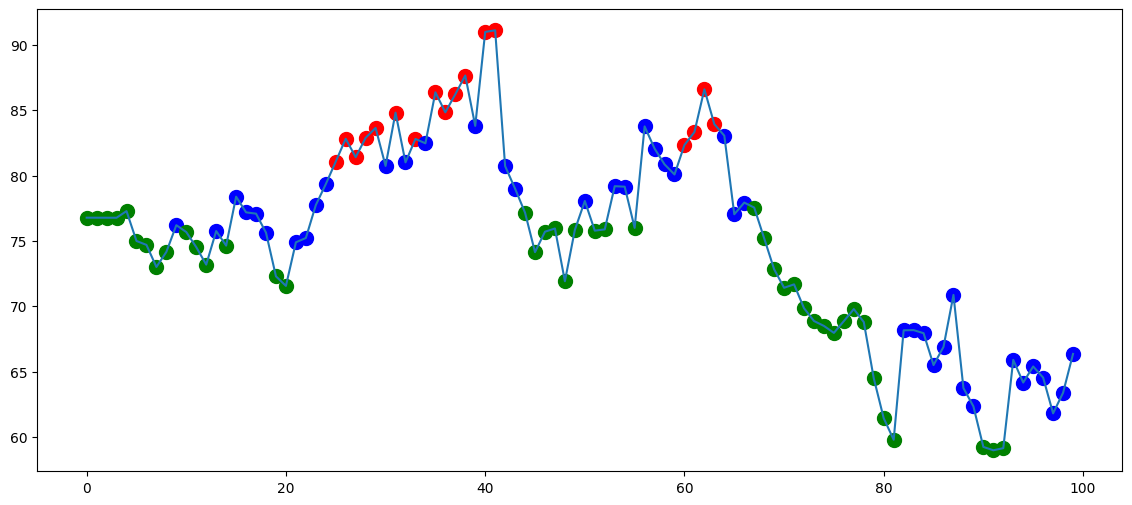

In [69]:

# Print the resulting DataFrame
plt.figure(figsize=(14,6))
plt.plot(submission['Close'])

colors = {'Sell': 'red', 'Hold': 'blue', 'Buy': 'green'}

for strategy in colors.keys():
    strategy_data = submission[submission['Strategy'] == strategy]
    plt.scatter(strategy_data.index, strategy_data['Close'], label=strategy, color=colors[strategy], s=100)


In [70]:
sample_submission = pd.read_csv('/kaggle/input/ue21cs342aa2/sample_submission.csv', index_col = 0)

In [71]:
# submission["Close"] = sample_submission["Close"]
# submission["Strategy"] = sample_submission["Strategy"]

### In the cell above, we have just provided an example of how to create your submission DataFrame. Please make sure to use **your own forecasts and predictions**, in place of `sample_submission["Close"]` and `sample_submission["Strategy"]`

In [72]:
submission.head()

,Date,Close,Strategy
id,,,
0,2021-03-01,76.776187,Buy
1,2021-03-08,76.774467,Buy
2,2021-03-15,76.772747,Buy
3,2021-03-22,76.771027,Buy
4,2021-03-29,77.278555,Buy


In [73]:
submission.to_csv('submission.csv', index=True)

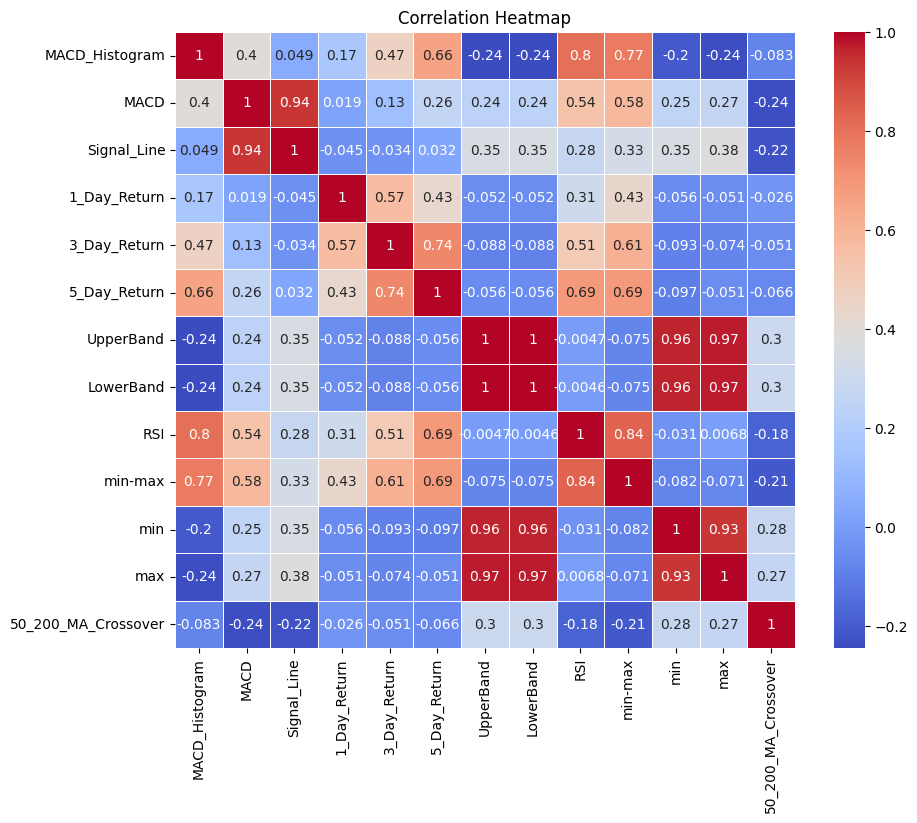

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with your data

# Calculate the correlation matrix
corr_matrix = X.corr()

# Create a correlation heatmap
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# anova

In [75]:
# from scipy import stats
# import pandas as pd


# # Create a DataFrame
# # df = pd.DataFrame(data)
# df = X.copy()  # Create a copy of the feature matrix
# df['Strategy'] = y 

# # List of feature columns
# feature_columns = df.columns[:-1]  # Exclude the 'Strategy' column

# # Perform ANOVA for each feature
# results = []
# for feature in feature_columns:
#     groups = [df[df['Strategy'] == strategy][feature] for strategy in df['Strategy'].unique()]
#     f_statistic, p_value = stats.f_oneway(*groups)
#     results.append({'Feature': feature, 'F-Statistic': f_statistic, 'P-Value': p_value})

# # Display the results
# anova_results = pd.DataFrame(results)
# print(anova_results)
